In [1]:
from scipy.integrate import quad, trapz, fixed_quad
import theano
import theano.tensor as T
from theano.tests.unittest_tools import verify_grad
from theano.compile.ops import as_op

import numpy as np
import pymc3 as pm

import matplotlib.pyplot as plt

import astropy.units as u

from tqdm import tqdm

from gammapy.spectrum import CountsPredictor, CountsSpectrum

from utils import load_spectrum_observations, plot_spectra, Log10Parabola, integrate_spectrum, wstat_profile
from forward_fold_model import model_probability, ln_profile_likelihood

%matplotlib inline

In [2]:
# theano.config.floatX ='float32'
# print(theano.config)
class Integrate(theano.Op):
    def __init__(self, expr, var, lower, upper, *inputs):
        super().__init__()
        self._expr = expr
        self._var = var
        self._extra_vars = inputs
        self.lower = lower
        self.upper = upper
        self._func = theano.function(
            [var] + list(self._extra_vars),
            self._expr,
            on_unused_input='ignore'
        )
    
    def make_node(self, *inputs):
        assert len(self._extra_vars)  == len(inputs)
        return theano.Apply(self, list(inputs), [T.dscalar().type()])
    
    def perform(self, node, inputs, out):
        x = np.linspace(self.lower, self.upper, num=3)
        y = np.array([self._func(i , *inputs) for i in x])
        val = trapz(y, x)
#         print(val)
#         val = quad(self._func, self.lower, self.upper, args=tuple(inputs))[0]
        out[0][0] = np.array(val)
        
    def grad(self, inputs, grads):
        out, = grads
        grads = T.grad(self._expr, self._extra_vars)
        dargs = []
        for grad in grads:
            integrate = Integrate(grad, self._var, self.lower, self.upper, *self._extra_vars)
            darg = out * integrate(*inputs)
            dargs.append(darg)
            
        return dargs

In [3]:
def apply_range(*arr, fit_range, bins):
    idx = np.searchsorted(bins.to(u.TeV).value, fit_range.to(u.TeV).value )
#     print(len(arr))
#     if len(arr) == 1:
#         print(arr)
    return [a[idx[0]:idx[1]] for a in arr]

def forward_fold_gammapy(amplitude, alpha, beta, observation):
#     bins = obs.on_vector.energy.bins
    model = Log10Parabola(
        amplitude=amplitude * 1e-11 * u.Unit('cm-2 s-1 TeV-1'),
        reference=1 * u.Unit('TeV'),
        alpha=alpha * u.Unit(''),
        beta=beta * u.Unit(''),
    )
    
    predictor = CountsPredictor(model=model, aeff=observation.aeff, edisp=observation.edisp, livetime=observation.livetime)
    predictor.run()
    counts = predictor.npred.data.data
#     counts *= observation.on_vector.areascal
    return counts.value

In [4]:
def forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observation, fit_range=None):

    obs_bins = observation.on_vector.energy
    aeff_bins = observation.aeff.energy
    e_reco_bins = observation.edisp.e_reco
    e_true_bins = observation.edisp.e_true
     
    if fit_range:
        lo = obs_bins.lo.min()
        hi = obs_bins.hi.max()
        lo = max(fit_range[0], lo).to_value(u.TeV)
        hi = min(fit_range[1], hi ).to_value(u.TeV)
    else:
        lo = obs_bins.lo.min().to_value(u.TeV)
        hi = obs_bins.hi.max().to_value(u.TeV)

    obs_mask = (obs_bins.lo.to_value(u.TeV) > lo ) & (obs_bins.hi.to_value(u.TeV) <= hi)
    aeff_mask = (aeff_bins.lo.to_value(u.TeV) > lo ) & (aeff_bins.hi.to_value(u.TeV) <= hi)
    e_reco_mask = (e_reco_bins.lo.to_value(u.TeV) > lo ) & (e_reco_bins.hi.to_value(u.TeV) <= hi)
    e_true_mask = (e_true_bins.lo.to_value(u.TeV) > lo ) & (e_true_bins.hi.to_value(u.TeV) <= hi)
    
   
    lower =  e_true_bins.lo[e_true_mask].to_value(u.TeV)
    upper = e_true_bins.hi[e_true_mask].to_value(u.TeV)

    amplitude *= 1e-11
    
    energy = T.dscalar('energy')
    amplitude_ = T.dscalar('amplitude_')
    alpha_ = T.dscalar('alpha_')
    beta_ = T.dscalar('beta_')

    func = amplitude_ * energy **(-alpha_ - beta_ * T.log10(energy))
    
    counts = []
    for a, b in zip(lower, upper):
        c = Integrate(func, energy, a, b, amplitude_, alpha_, beta_)(amplitude, alpha, beta)
        counts.append(c)

    counts = T.stack(counts)
    aeff = observation.aeff.data.data.to_value(u.cm**2).astype(np.float32)[aeff_mask]
    aeff = T.constant(aeff)
    

    counts *= aeff
    counts *= theano.shared(observation.livetime.to_value(u.s))
    edisp = observation.edisp.pdf_matrix[e_true_mask]
    edisp = T.constant(edisp)
    
    return T.dot(counts, edisp)

In [5]:
obs_list, fit_range = load_spectrum_observations('fact')
observation = obs_list[0]
energy_bins = observation.on_vector.energy.bins

In [6]:
def wstat_model(amplitude, alpha, beta, observation, fit_range):
    mu_sig = forward_fold_gammapy(amplitude, alpha, beta, observation=observation)
#     print(mu_sig.shape)
    on_data = observation.on_vector.data.data.value
    off_data = observation.off_vector.data.data.value
    
    mu_sig, on_data, off_data, obs_alpha = apply_range(mu_sig, on_data, off_data, observation.alpha, fit_range=fit_range, bins=energy_bins)
    p = ln_profile_likelihood(mu_sig, on_data, off_data, alpha=obs_alpha)
    p = -0.5*sum(p)
#     print('Prob:', p)
#     print('n_on:', on_data)
#     print('n_off:', off_data)
#     print('obs_alpha:', obs_alpha)
    return p, mu_sig

wstat_model(4, 2, 0.5, observation, fit_range=fit_range)

(6011.934915181168,
 array([ 2.83641875,  5.03451983,  8.58513145, 13.73386645, 20.43515058,
        27.81452573, 34.29191945, 39.77983177, 43.17620902, 43.75214362,
        43.23565957, 40.99682698, 36.98690407, 33.15867575, 29.14912131,
        24.9871197 , 21.71731737, 18.67498731, 15.63194352, 13.21337521,
        11.05064186,  9.0374708 ,  7.52087301,  6.18769006,  4.93665392,
         3.97537069,  3.13799023,  2.4017132 ,  1.86052837,  1.42260807,
         1.05535167,  0.78090854,  0.54856758,  0.35638484]))

In [13]:
def wstat_model_symbolic(mu_sig, observation, fit_range):
    on_data = observation.on_vector.data.data.value
    off_data = observation.off_vector.data.data.value
    
    mu_sig, on_data, off_data, obs_alpha = apply_range(mu_sig, on_data, off_data, observation.alpha, fit_range=fit_range, bins=energy_bins)
    p = ln_profile_likelihood(mu_sig, on_data, off_data, alpha=obs_alpha)
    p = -0.5*sum(p)
    return p, mu_sig

In [14]:
amplitude = T.dscalar('amplitude')
alpha = T.dscalar('alpha')
beta = T.dscalar('beta')
cf = forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observation)
counts_symbolic = cf.eval({amplitude: 4.0, alpha: 2.0, beta: 0.5})
counts_symbolic = apply_range(counts_symbolic, fit_range=fit_range, bins=energy_bins)[0]

_, counts_gammapy = wstat_model(4, 2, 0.5, observation, fit_range=fit_range)

_, counts_emcee = model_probability([4, 2, 0.5], [observation], fit_range=fit_range)

counts_symbolic, counts_gammapy, counts_emcee

(array([ 2.84025332,  5.04124389,  8.59653947, 13.75222054, 20.46277659,
        27.85280276, 34.34030109, 39.83747791, 43.24062197, 43.81950991,
        43.30430585, 41.06400937, 37.04957655, 33.21675532, 29.2019266 ,
        25.03393839, 21.75930759, 18.71221531, 15.6640727 , 13.24134702,
        11.07473968,  9.0577734 ,  7.53825383,  6.20239515,  4.94870911,
         3.98533556,  3.14605724,  2.40804934,  1.86555152,  1.42651212,
         1.0582746 ,  0.78305883,  0.55000366,  0.35720872]),
 array([ 2.83641875,  5.03451983,  8.58513145, 13.73386645, 20.43515058,
        27.81452573, 34.29191945, 39.77983177, 43.17620902, 43.75214362,
        43.23565957, 40.99682698, 36.98690407, 33.15867575, 29.14912131,
        24.9871197 , 21.71731737, 18.67498731, 15.63194352, 13.21337521,
        11.05064186,  9.0374708 ,  7.52087301,  6.18769006,  4.93665392,
         3.97537069,  3.13799023,  2.4017132 ,  1.86052837,  1.42260807,
         1.05535167,  0.78090854,  0.54856758,  0.35638484]),


In [16]:
amplitude = T.dscalar('amplitude')
alpha = T.dscalar('alpha')
beta = T.dscalar('beta')
cf = forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observation)
mu_sig = cf.eval({amplitude: 4.0, alpha: 2.0, beta: 0.5})

p_symbolic, counts_symbolic = wstat_model_from_counts(mu_sig, observation, fit_range=fit_range)
p_gammapy, counts_gammapy = wstat_model(4, 2, 0.5, observation, fit_range=fit_range)

p_emcee, counts_emcee = model_probability([4, 2, 0.5], [observation], fit_range=fit_range)

p_symbolic, p_gammapy, p_emcee

(6011.801813073105, 6011.934915181168, 6011.934915181169)

625it [00:01, 338.98it/s]


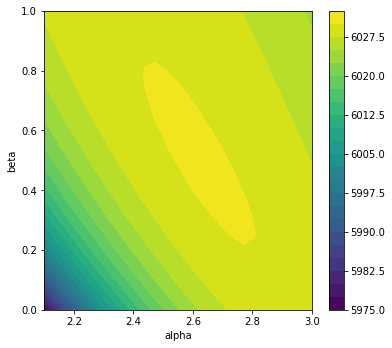

In [17]:

N = 25
betas = np.linspace(0, 1, N)
alphas = np.linspace(2.1, 3.0, N)
a, b = np.meshgrid(alphas, betas)

zs = []
for alpha, beta in tqdm(zip(a.ravel(), b.ravel())):
    p, _ = model_probability([4, alpha, beta], [observation], fit_range=fit_range)
    zs.append(p)

zs = np.array(zs)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5.5))
cf = ax1.contourf(a, b, zs.reshape(len(a), -1),  levels=24)
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
plt.colorbar(cf, ax=ax1)

625it [00:01, 329.09it/s]


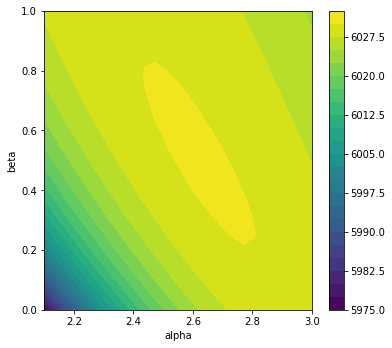

In [18]:
N = 25
betas = np.linspace(0, 1, N)
alphas = np.linspace(2.1, 3.0, N)
a, b = np.meshgrid(alphas, betas)

zs = []
for alpha, beta in tqdm(zip(a.ravel(), b.ravel())):
    p, _ = wstat_model(4, alpha, beta, observation, fit_range=fit_range)
    zs.append(p)

zs = np.array(zs)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5.5))
cf = ax1.contourf(a, b, zs.reshape(len(a), -1),  levels=24)
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
plt.colorbar(cf, ax=ax1)

625it [00:11, 53.18it/s]


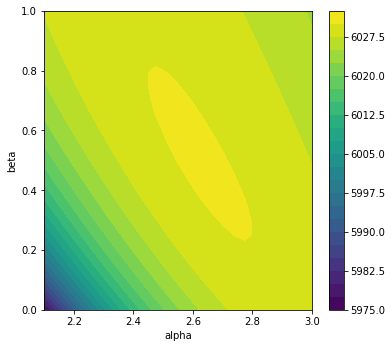

In [19]:
N = 25
betas = np.linspace(0, 1, N)
alphas = np.linspace(2.1, 3.0, N)



amplitude = T.dscalar('amplitude')
alpha = T.dscalar('alpha')
beta = T.dscalar('beta')
cf = forward_fold_log_parabola_symbolic(amplitude, alpha, beta, observation)

zs = []
a, b = np.meshgrid(alphas, betas)
for al, be in tqdm(zip(a.ravel(), b.ravel())):
    mu_sig = cf.eval({amplitude: 4.0, alpha: al, beta: be})
    
    p, _ = wstat_model_from_counts(mu_sig, observation, fit_range=fit_range)
    zs.append(p)

zs = np.array(zs)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5.5))
cf = ax1.contourf(a, b, zs.reshape(len(a), -1),  levels=24)
ax1.set_xlabel('alpha')
ax1.set_ylabel('beta')
plt.colorbar(cf, ax=ax1)